In [1]:
import pandas as pd
import numpy as np
import time
import random
import lightgbm as lgb
import time
from multiprocessing import Process, Pool
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
from keras.models import load_model

Using TensorFlow backend.


In [2]:
from process import map_feature

In [3]:
FOLDER = '../../data_kaggle/champs/'
OUTPUT = FOLDER + 'out/'
TEMP = OUTPUT + 'temp/'
MAP  = OUTPUT + 'map/'

In [4]:
# original dataset


In [5]:
DATA_DATE = '20190721'
MAP_DATE = '20190728'
MODEL_DATE = '20190821'

In [6]:
# input files
trained_models =  OUTPUT + MODEL_DATE + '_' + 'champs_models_nn_{}.h5'

merged_model =  OUTPUT + MODEL_DATE + '_' + 'merged_nn_{}.h5'
mols_split = OUTPUT + MODEL_DATE + '_' + 'molecule_name_split.pickle'

map_train = MAP + MAP_DATE + '_' + 'map_train.pickle'
map_test = MAP + MAP_DATE + '_' + 'map_test.pickle'

first_train = OUTPUT + DATA_DATE + '_' + 'features_train.pickle'
first_test = OUTPUT + DATA_DATE + '_' + 'features_test.pickle'

In [7]:
with open(first_train, 'rb') as f:
    features_train = pickle.load(f)

In [8]:
df_map_train = pd.read_pickle(map_train).sort_values('id')
df_map_train_idx = df_map_train.set_index('id')

In [9]:
bond_types = ['1JHC', '1JHN', '2JHH', '2JHC', '2JHN', '3JHH', '3JHC', '3JHN']

In [10]:
from keras.layers import Input
from keras.layers import Dense
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.models import load_model
from keras.layers import Concatenate

In [26]:
b_target = bond_types[0]
model_target = load_model(trained_models.format(b_target), compile=False)
for l in model_target.layers:
    l.name = l.name + '_' + b_target

models_add = []
for b in bond_types:
    for i in range(3):
        model_add = load_model(trained_models.format(b), compile=False)
        for l in model_add.layers:
            l.name = l.name + '_' + b + '_' + 'x' + '_' + str(i)
        models_add.append(model_add)

for b in bond_types:
    for i in range(3):
        model_add = load_model(trained_models.format(b), compile=False)
        for l in model_add.layers:
            l.name = l.name + '_' + b + '_' + 'y' + '_' + str(i)
        models_add.append(model_add)

input_list = [model_target.input]
in_list_temp = [models_add[i].input for i in range(len(models_add))]
input_list.extend(in_list_temp)

output_list = [model_target.layers[-2].output]
out_list_temp = [models_add[i].layers[-2].output for i in range(len(models_add))]
output_list.extend(out_list_temp)

conc_output = Concatenate(name='concat_out1')(output_list)

# model.save(merged_models.format(b_target), include_optimizer=False)

In [28]:
dense_merge0 = Dense(400, activation='relu', name='dense_merge0')(conc_output)
norm_merge0 = BatchNormalization(name='norm_merge0')(dense_merge0)
dense_merge1 = Dense(100, activation='tanh', name='dense_merge1')(norm_merge0)
norm_merge1 = BatchNormalization(name='norm_merge1')(dense_merge1)
dense_merge2 = Dense(1, name='dense_merge2')(norm_merge1)
# norm_merge2 = BatchNormalization(name='norm_merge2')(dense_merge2)
# dense_merge3 = Dense(100, activation='tanh', name='dense_merge3')(norm_merge2)
# norm_merge3 = BatchNormalization(name='norm_merge3')(dense_merge3)
# dense_merge4 = Dense(50, activation='relu', name='dense_merge4')(norm_merge3)
# norm_merge4 = BatchNormalization(name='norm_merge4')(dense_merge4)
# dense_merge5 = Dense(10, activation='tanh', name='dense_merge5')(norm_merge4)
# norm_merge5 = BatchNormalization(name='norm_merge5')(dense_merge5)
# dense_merge6 = Dense(1, name='dense_merge6')(norm_merge5)

model = Model(input_list, dense_merge2)

In [29]:
for layer in model.layers[:-6]:
    layer.trainable = False

In [30]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1JHC (InputLayer)         (None, 215)          0                                            
__________________________________________________________________________________________________
input_1JHC_x_0 (InputLayer)     (None, 215)          0                                            
__________________________________________________________________________________________________
input_1JHC_x_1 (InputLayer)     (None, 215)          0                                            
__________________________________________________________________________________________________
input_1JHC_x_2 (InputLayer)     (None, 215)          0                                            
__________________________________________________________________________________________________
input_1JHN

In [15]:
def gen_merged_features(df_map_idx, features, idx_arr):
    merged_features = np.zeros([len(idx_arr), 49, 215])
    for j, idx in enumerate(idx_arr):
        pickup_ids = df_map_idx.loc[idx].values[:-1]
        for i, p in enumerate(pickup_ids):
            if p == -1:
                continue
            merged_features[j, i, :] = features[p]
    return merged_features

In [16]:
def get_sc(df_idx, idx_arr):
    return df_idx.loc[idx_arr]['scalar_coupling_constant'].values

In [17]:
def data_flow(df_idx, df_map_idx, features, idx, batch_size=32):
    while True:
        idx_arr = np.array(random.sample(list(idx), batch_size))
        inputs = gen_merged_features(df_map_idx, features, idx_arr)
        input_list = []
        num_input = inputs.shape[1]
        for i in range(num_input):
            input_list.append(inputs[:,i,:])
        targets = get_sc(df_idx, idx_arr)
        yield input_list, targets

In [18]:
def data_flow_val(df_idx, df_map_idx, features, idx, batch_size=32):
    num_batch = len(idx) // batch_size
    j = 0
    while True:
        if j != num_batch:
            idx_arr = idx[batch_size*j:batch_size*(j+1)]
        else:
            idx_arr = idx[batch_size*j:]
        inputs = gen_merged_features(df_map_idx, features, idx_arr)
        input_list = []
        num_input = inputs.shape[1]
        for i in range(num_input):
            input_list.append(inputs[:,i,:])
        j += 1
        yield input_list

In [19]:
with open(mols_split, 'rb') as f:
    mols_train = pickle.load(f)
    mols_val = pickle.load(f)

In [20]:
df = pd.read_csv(FOLDER + 'train.csv')

In [21]:
b = bond_types[0]
df_train = df[df['molecule_name'].isin(mols_train)].query('type == "{}"'.format(b))
df_val = df[df['molecule_name'].isin(mols_val)].query('type == "{}"'.format(b))

df_train_idx = df_train.set_index('id')
df_val_idx = df_val.set_index('id')

idx_train = df_train_idx.index.values
idx_val = df_val_idx.index.values

In [31]:
# model = load_model(merged_model.format(b), compile=False)
model.compile(loss='mean_absolute_error', optimizer='adam')

In [32]:
batch = 128
gen_train = data_flow(df_train_idx, df_map_train_idx, features_train, idx_train, batch_size=batch)
gen_val = data_flow(df_val_idx, df_map_train_idx, features_train, idx_val, batch_size=batch)
# gen_val = data_flow_val(df_train_idx, df_map_train_idx, features_train, idx_train, batch_size=batch)


In [33]:
steps_train = len(idx_train) // batch
steps_val = len(idx_val) // batch

In [37]:
model.fit_generator(gen_train, steps_per_epoch=steps_train, epochs=50, verbose=1, validation_data=gen_val, validation_steps=steps_val)

Epoch 1/50
4986/4986 [==============================] - 402s 81ms/step - loss: 1.7971 - val_loss: 5.8560
Epoch 2/50
4986/4986 [==============================] - 439s 88ms/step - loss: 1.7849 - val_loss: 7.6759
Epoch 3/50
4986/4986 [==============================] - 419s 84ms/step - loss: 1.7341 - val_loss: 10.7725
Epoch 4/50
4986/4986 [==============================] - 436s 87ms/step - loss: 1.7440 - val_loss: 10.5926
Epoch 5/50
4986/4986 [==============================] - 434s 87ms/step - loss: 1.7120 - val_loss: 11.6608
Epoch 6/50
4986/4986 [==============================] - 440s 88ms/step - loss: 1.6922 - val_loss: 11.4878
Epoch 7/50
3153/4986 [=================>............] - ETA: 2:28 - loss: 1.6982

KeyboardInterrupt: 

In [38]:
gen_train_val = data_flow_val(df_train_idx, df_map_train_idx, features_train, idx_train, batch_size=batch)
gen_val_val = data_flow_val(df_val_idx, df_map_train_idx, features_train, idx_val, batch_size=batch)

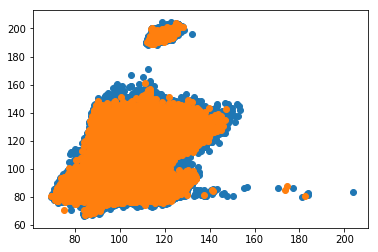

In [39]:
y_pred_train = model.predict_generator(gen_train_val, steps=steps_train+1)
y_pred_val = model.predict_generator(gen_val_val, steps=steps_val+1)
y_train = df_train_idx.loc[idx_train]['scalar_coupling_constant'].values
y_val = df_val_idx.loc[idx_val]['scalar_coupling_constant'].values
plt.scatter(y_pred_train, y_train)
plt.scatter(y_pred_val, y_val)
plt.show()